In [2]:
import os
import pandas as pd
import yfinance as yf

from polygon import RESTClient
from pathlib import Path
from dotenv import load_dotenv

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

load_dotenv()
os.getcwd()

'/workspace/user/kjy/DL-projects/MAS/04-langgraph-projects/04-multi-agent-business-analysis'

### Polygon API

In [3]:
BASE_DIR = Path(os.getcwd())    # 현재 작업 디렉토리
DATA_DIR = BASE_DIR / "data"    # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / "charts" # 차트 저장용 디렉토리

In [4]:
polygon_client = RESTClient(api_key=os.environ["POLYGON_API_KEY"])

### yfinance, Polygon API로 자사, 경쟁사 주식정보 가져오기

In [5]:
related_companies = polygon_client.get_related_companies("NVDA")

competitors = [i.ticker for i in related_companies]
competitors

['AMD',
 'META',
 'GOOGL',
 'TSLA',
 'GOOG',
 'MSFT',
 'AMZN',
 'AAPL',
 'INTC',
 'AVGO']

In [7]:
nasdaq = yf.download('^IXIC', start="2023-01-01", end="2024-01-01", progress=False)

In [13]:
nasdaq

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC
Date,,,,,,
2023-01-03 00:00:00+00:00,10386.980469,10386.980469,10613.059570,10309.160156,10562.059570,4780650000
2023-01-04 00:00:00+00:00,10458.759766,10458.759766,10515.219727,10337.639648,10467.820312,5085380000
2023-01-05 00:00:00+00:00,10305.240234,10305.240234,10393.219727,10295.250000,10390.309570,4764270000
2023-01-06 00:00:00+00:00,10569.290039,10569.290039,10604.139648,10265.040039,10363.959961,5199780000
2023-01-09 00:00:00+00:00,10635.650391,10635.650391,10807.259766,10619.120117,10662.099609,5132190000
...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,14992.969727,14992.969727,15047.190430,14927.120117,15006.179688,4796600000
2023-12-26 00:00:00+00:00,15074.570312,15074.570312,15101.179688,15024.059570,15028.690430,6120600000


In [14]:
df = pd.DataFrame(index=nasdaq.index) # 기간을 인덱스로 설정
df['^IXIC'] = nasdaq['Adj Close']

In [16]:
df.empty

False

In [17]:
@tool
def fetch_stock_data(ticker: str, start_date: str, end_date: str):
    """Fetch stock data and compare with NASDAQ and competitors."""
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
    nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False)

    df = pd.DataFrame(index=stock.index) # 기간을 인덱스로 설정
    df[f'{ticker}'] = stock['Adj Close']
    df['Nasdaq'] = nasdaq['Adj Close']

    related_companies = polygon_client.get_related_companies(ticker)
    competitors = [i.ticker for i in related_companies]

    for comp in competitors:
        try:
            comp_ticker = comp.replace('.', '-') if '.' in comp else comp
            comp_data = yf.download(comp_ticker, start=start_date, end=end_date, progress=False)
            if not comp_data.empty:
                df[comp] = comp_data['Adj Close']
        except Exception as e:
            continue

    csv_path = DATA_DIR / "stock_data.csv"
    df.to_csv(csv_path)
    return f"Stock file saved to {csv_path}"

In [23]:
fetch_stock_data.run({"ticker": "NVDA",
                      "start_date":"2023-01-01", 
                      "end_date":"2024-01-01"})

'Stock file saved to /workspace/user/kjy/DL-projects/MAS/04-langgraph-projects/04-multi-agent-business-analysis/data/stock_data.csv'

### Get Financial Information

In [32]:
import time

client = polygon_client

# 최근 n개년간 분기별 재무제표 데이터 수집
financials = []
for f in client.vx.list_stock_financials("NVDA", limit=30): # limit을 지정하지 않으면 요청수가 초과할 수 있다.
    if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - 3}-01-01":
        financials.append(f)
    # time.sleep(1)  # 요청 간 1초 지연

In [33]:
financials

[StockFinancial(cik='0001045810', company_name='NVIDIA CORP', end_date='2024-07-28', filing_date='2024-08-28', financials=Financials(balance_sheet={'intangible_assets': DataPoint(formula=None, label='Intangible Assets', order=330, unit='USD', value=952000000.0, xpath=None), 'equity_attributable_to_parent': DataPoint(formula=None, label='Equity Attributable To Parent', order=1600, unit='USD', value=58157000000.0, xpath=None), 'inventory': DataPoint(formula=None, label='Inventory', order=230, unit='USD', value=6675000000.0, xpath=None), 'liabilities': DataPoint(formula=None, label='Liabilities', order=600, unit='USD', value=27070000000.0, xpath=None), 'other_noncurrent_assets': DataPoint(formula=None, label='Other Non-current Assets', order=350, unit='USD', value=19757000000.0, xpath=None), 'other_noncurrent_liabilities': DataPoint(formula=None, label='Other Non-current Liabilities', order=820, unit='USD', value=4640000000.0, xpath=None), 'accounts_payable': DataPoint(formula=None, label

In [35]:
@tool
def get_financial_data(ticker: str, num_years: int):
    """
    주어진 티커의 재무 데이터를 가져와 DataFrame으로 저장하고 파일 경로를 반환합니다.
    
    Parameters:
    ticker (str): 종목 코드
    num_years (int): 가져올 연도 수
    
    Returns:
    str: 저장된 파일 경로 메시지
    """

    client = polygon_client

    # 최근 n개년간 분기별 재무제표 데이터 수집
    financials = []
    for f in client.vx.list_stock_financials(ticker, limit=30):
        if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - num_years}-01-01":
            financials.append(f)

    # DataFrame 생성할 데이터 목록 초기화
    data = {
        # 기본 정보
        "Fiscal Year": [],
        "Fiscal Period": [],
        "End Date": [],
        
        # 손익계산서 항목
        "Revenues": [],
        "Cost of Revenue": [],
        "Gross Profit": [],
        "Operating Income": [],
        "Operating Expenses": [],
        "Basic EPS": []
    }

    # 각 재무제표 항목에서 지표들을 추출하여 DataFrame 구성
    for i, f in enumerate(financials):
        data["Fiscal Year"].append(f.fiscal_year)
        data["Fiscal Period"].append(f.fiscal_period)
        data["End Date"].append(f.end_date)

        bs = f.financials.balance_sheet
        is_ = f.financials.income_statement
        cf = f.financials.cash_flow_statement
        ci = f.financials.comprehensive_income

        revenue = getattr(is_.revenues, 'value', None) if hasattr(is_, 'revenues') else None
        data["Revenues"].append(revenue)
        data["Cost of Revenue"].append(getattr(is_.cost_of_revenue, 'value', None) if hasattr(is_, 'cost_of_revenue') else None)
        data["Gross Profit"].append(getattr(is_.gross_profit, 'value', None) if hasattr(is_, 'gross_profit') else None)
        data["Operating Expenses"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Operating Income"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Basic EPS"].append(getattr(is_.basic_earnings_per_share, 'value', None) if hasattr(is_, 'basic_earnings_per_share') else None)

    df = pd.DataFrame(data)
    df.sort_values(by="End Date", ascending=False, inplace=True)

    # 한글 컬럼명으로 변경
    korean_columns = {
        "Fiscal Year": "회계연도",
        "Fiscal Period": "회계기간",
        "End Date": "기준일",
        "Revenues": "매출액",
        "Cost of Revenue": "매출원가",
        "Gross Profit": "매출총이익",
        "Operating Income": "영업이익",
        "Operating Expenses": "영업비용",
        "Basic EPS": "기본주당순이익"
    }
    
    df.rename(columns=korean_columns, inplace=True)

    csv_path = DATA_DIR / "finance_data.csv"
    df.to_csv(csv_path, encoding='utf-8-sig')
    return f"재무제표 데이터가 {csv_path}에 저장되었습니다."

In [36]:
get_financial_data.run({"ticker": "NVDA", "num_years": 3})

'재무제표 데이터가 /workspace/user/kjy/DL-projects/MAS/04-langgraph-projects/04-multi-agent-business-analysis/data/finance_data.csv에 저장되었습니다.'

### create_pandas_dataframe_agent로 데이터 분석 도구 만들기

In [38]:
@tool
def analyze_data(query: str):
    """저장된 주식 데이터와 재무 데이터를 pandas_agent로 분석하고 질문에 답변한다."""
    stock_csv_path = DATA_DIR / "stock_data.csv"
    finance_csv_path = DATA_DIR / "finance_data.csv"
    stock_df = pd.read_csv(stock_csv_path)
    finance_df = pd.read_csv(finance_csv_path)
    custom_prefix = f"""
    You are very smart analyst who can use stock_data and finance_data.
    Please analyze the data in various perspective to find valuable insight.
    You should always make the greatest output with accurate metrics and tables.
    stock_data path: {stock_csv_path}
    finance_data path: {finance_csv_path}
    """

    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        [stock_df, finance_df],
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix=custom_prefix
    )

    result = pandas_agent.run(query)
    return result

/tmp/ipykernel_69293/2367182442.py:25: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = pandas_agent.run(query)




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the stock data\ndf_stock = pd.read_csv('/workspace/user/kjy/DL-projects/MAS/04-langgraph-projects/04-multi-agent-business-analysis/data/stock_data.csv')\n\n# Convert 'Date' column to datetime format\ndf_stock['Date'] = pd.to_datetime(df_stock['Date'])\n\n# Set 'Date' as the index\ndf_stock.set_index('Date', inplace=True)\n\n# Plot the NVDA stock price trend\ndf_stock['NVDA'].plot(figsize=(12, 6))\nplt.title('NVDA Stock Price Trend')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.grid(True)\nplt.show()"}`




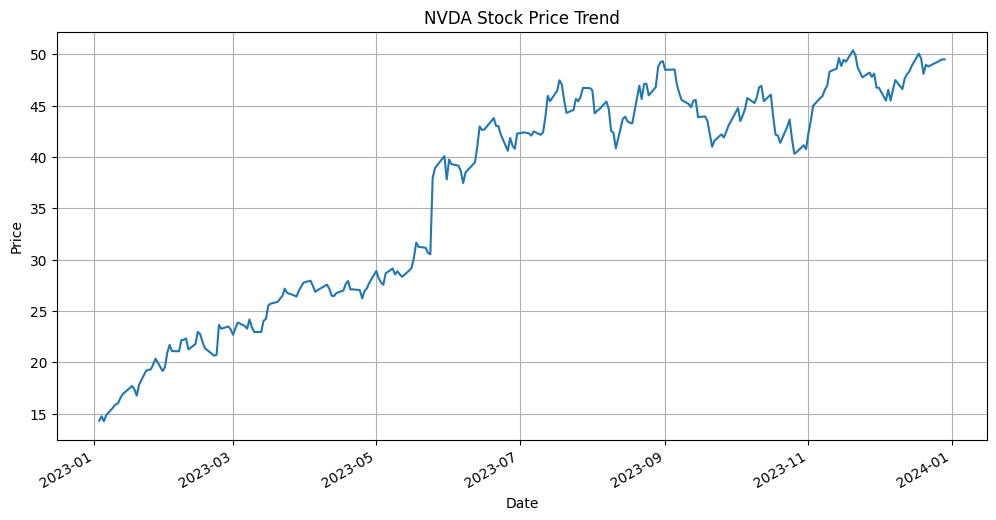

The trend of NVDA stock prices has been plotted. Please take a look at the graph to see how the prices have fluctuated over time. If you have any specific questions or need further analysis, feel free to ask!

> Finished chain.


'The trend of NVDA stock prices has been plotted. Please take a look at the graph to see how the prices have fluctuated over time. If you have any specific questions or need further analysis, feel free to ask!'

In [39]:
analyze_data.run({"query":"NVDA 가격 추이를 분석해줘"})

### Create chart

In [40]:
save_path = "/workspace/user/kjy/DL-projects/MAS/04-langgraph-projects/04-multi-agent-business-analysis/charts"
os.makedirs(save_path, exist_ok=True)

In [41]:
@tool
def chart_generator(command: str):
    """이 도구는 create_pandas_dataframe_agent를 사용하여 차트를 생성하고 차트를 /charts 폴더에 저장합니다."""
    stock_data = pd.read_csv(DATA_DIR / "stock_data.csv")
    finance_data = pd.read_csv(DATA_DIR / "finance_data.csv")
    custom_prefix = """
    Please make the chart and save in './charts' folder.
    stock_data path is './data/stock_data.csv'.
    finance_data path is './data/finance_data.csv'
    """
    agent = create_pandas_dataframe_agent(
        ChatOpenAI(model_name="gpt-4o"), 
        [stock_data, finance_data], 
        verbose=True,
        allow_dangerous_code=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        prefix=custom_prefix
    )
    result = agent.invoke(command)
    return result

In [42]:
chart_generator.run({"command":"NVDA stock price chart"})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the stock data\ndf = pd.read_csv('./data/stock_data.csv')\n\n# Convert the 'Date' column to datetime format\ndf['Date'] = pd.to_datetime(df['Date'])\n\n# Plot NVDA stock price over time\nplt.figure(figsize=(10, 6))\nplt.plot(df['Date'], df['NVDA'], label='NVDA', color='blue')\nplt.title('NVDA Stock Price Over Time')\nplt.xlabel('Date')\nplt.ylabel('Stock Price')\nplt.legend()\nplt.grid(True)\n\n# Save the chart to the './charts' folder\nplt.savefig('./charts/nvda_stock_price_chart.png')\nplt.close()"}`


The NVDA stock price chart has been created and saved in the './charts' folder as 'nvda_stock_price_chart.png'.

> Finished chain.


{'input': 'NVDA stock price chart',
 'output': "The NVDA stock price chart has been created and saved in the './charts' folder as 'nvda_stock_price_chart.png'."}